In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.io import mmread
from scipy.sparse import csr_matrix
import pickle as pkl

from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

import gc

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

import scib_metrics as sm
import sys
import os
sys.path.append('/'.join(os.getcwd().split('/')[:-1]+['eval','cleaned','']))
from metrics import ilisi,asw_batch

In [ ]:
path_data='/net/bmc-lab4/data/kellis/users/khrovati/data/'
path_mm=path_data+'datasets/d10_1101_2022_12_22_521557/'
path_genes=path_data+'gene_info/'
path_hs=path_data+'datasets/d10_1101_2023_02_03_526994/'
path_save=path_data+'cross_system_integration/pancreas_conditions_MIA_HPAP2/'

In [ ]:
# Orthologues
orthology_info=pd.read_table(path_genes+'orthologues_ORGmus_musculus_ORG2homo_sapiens_V109.tsv'
                         ).rename(
    {'Gene name':'gs_mm','Human gene name':'gs_hs',
     'Gene stable ID':'eid_mm','Human gene stable ID':'eid_hs'},axis=1)

# One-to-one orthologues

## Prepare data for integration

In [6]:
# One to one orthologues - dont have same mm/hs gene in the table 2x
oto_orthologues=orthology_info[~orthology_info.duplicated('eid_mm',keep=False).values & 
               ~orthology_info.duplicated('eid_hs',keep=False).values]

In [7]:
oto_orthologues.shape

(17131, 4)

### Mouse

In [8]:
adata_mm=sc.read(path_mm+'GSE211799_adata_atlas.h5ad')

In [10]:
adata_mm

AnnData object with n_obs × n_vars = 301796 × 31706
    obs: 'study_sample', 'study', 'file', 'reference', 'size_factors_sample', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'sex', 'ins_score', 'ins_high', 'gcg_score', 'gcg_high', 'sst_score', 'sst_high', 'ppy_score', 'ppy_high', 'cell_filtering', 'age', 'strain', 'tissue', 'technique', 'study_sample_design', 'cell_type', 'cell_type_multiplet', 'cell_subtype', 'cell_subtype_multiplet', 'design', 'size_factors_integrated', 'pre_cell_type_unified', 'pre_cell_type_original', 'study_parsed', 'cell_type_parsed', 'low_q', 'BETA-DATA_leiden_r1.5', 'BETA-DATA_leiden_r20', 'BETA-DATA_hc_gene_programs', 'BETA-DATA_hc_gene_programs_parsed', 'BETA-DATA_leiden_r1.5_parsed', 'BETA-DATA_leiden_r1.5_parsed_const', 'CXG-DATA_n_genes', 'CXG-DATA_mt_frac', 'CXG-DATA_doublet_score', 'CXG-DATA_log10_n_counts', 'CXG-DATA_age_approxDays', 'CXG-DATA_cell_subtype_immune_reannotatedIntegrated', 'CXG-DATA_cell_subtype_endothelial_reannotatedIntegr

In [12]:
# Remove embryo and other cts that cant be used
adata_mm=adata_mm[adata_mm.obs.study!='embryo',:]
adata_mm=adata_mm[~adata_mm.obs.cell_type_integrated_v2_parsed.isin(
    ['E endo.','E non-endo.','lowQ',]),:]

In [17]:
# Add raw expression to X, remove lowly expr genes, and normalise
adata_mm_raw=adata_mm.raw.to_adata()
adata_mm=adata_mm_raw.copy()
adata_mm.layers['counts']=adata_mm_raw[adata_mm.obs_names,adata_mm.var_names].X.copy()
del adata_mm_raw
adata_mm=adata_mm[:,np.array((adata_mm.X>0).sum(axis=0)>20).ravel()]
adata_mm=adata_mm[:,[g for g in oto_orthologues.eid_mm if g in adata_mm.var_names]]
sc.pp.normalize_total(adata_mm, target_sum=1e4)
sc.pp.log1p(adata_mm)

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
# HVGs on the final cell subset
sc.pp.highly_variable_genes(
     adata=adata_mm, n_top_genes=3000, flavor='cell_ranger', batch_key='study_sample',
    subset=True)
adata_mm.shape

(263140, 3000)

In [25]:
adata_mm

AnnData object with n_obs × n_vars = 263140 × 3000
    obs: 'study_sample', 'study', 'file', 'reference', 'size_factors_sample', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'sex', 'ins_score', 'ins_high', 'gcg_score', 'gcg_high', 'sst_score', 'sst_high', 'ppy_score', 'ppy_high', 'cell_filtering', 'age', 'strain', 'tissue', 'technique', 'study_sample_design', 'cell_type', 'cell_type_multiplet', 'cell_subtype', 'cell_subtype_multiplet', 'design', 'size_factors_integrated', 'pre_cell_type_unified', 'pre_cell_type_original', 'study_parsed', 'cell_type_parsed', 'low_q', 'BETA-DATA_leiden_r1.5', 'BETA-DATA_leiden_r20', 'BETA-DATA_hc_gene_programs', 'BETA-DATA_hc_gene_programs_parsed', 'BETA-DATA_leiden_r1.5_parsed', 'BETA-DATA_leiden_r1.5_parsed_const', 'CXG-DATA_n_genes', 'CXG-DATA_mt_frac', 'CXG-DATA_doublet_score', 'CXG-DATA_log10_n_counts', 'CXG-DATA_age_approxDays', 'CXG-DATA_cell_subtype_immune_reannotatedIntegrated', 'CXG-DATA_cell_subtype_endothelial_reannotatedIntegra

### Human

In [23]:
adata_hs=sc.read(path_hs+'hpap_islet_scRNAseq.h5ad')

In [30]:
adata_hs

AnnData object with n_obs × n_vars = 192203 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent MT', 'Seurat Clusters', 'Library', 'Sex', 'Diabetes Status', 'Tissue Source', 'Chemistry', 'Cell Type', 'Cell Type Grouped'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [33]:
# Add raw expression to X, remove lowly expr genes, and normalise
adata_hs=adata_hs[:,np.array((adata_hs.X>0).sum(axis=0)>20).ravel()]
gs=set(adata_hs.var_names)
adata_hs=adata_hs[:,[g for g in set(oto_orthologues.gs_hs.values) if g in gs]]
adata_hs.layers['counts']=adata_hs.X.copy()
sc.pp.normalize_total(adata_hs, target_sum=1e4)
sc.pp.log1p(adata_hs)

In [34]:
# HVGs on the final cell subset
sc.pp.highly_variable_genes(
     adata=adata_hs, n_top_genes=3000, flavor='cell_ranger', batch_key='Library',
    subset=True)
adata_hs.shape

(192203, 3000)

In [35]:
adata_hs

AnnData object with n_obs × n_vars = 192203 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent MT', 'Seurat Clusters', 'Library', 'Sex', 'Diabetes Status', 'Tissue Source', 'Chemistry', 'Cell Type', 'Cell Type Grouped'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

### Shared genes

In [38]:
# Find shared HVGs
gs_hs=set(adata_hs.var_names)
eids_mm=set(adata_mm.var_names)
shared_orthologues=oto_orthologues.query('gs_hs in @gs_hs')
shared_orthologues=shared_orthologues.query('eid_mm in @eids_mm')
print('N shared:',shared_orthologues.shape[0])

N shared: 1768


In [39]:
# Subset adatas to shared HVGs
# This already ensures same gene order
adata_hs=adata_hs[:,shared_orthologues.gs_hs]
adata_mm=adata_mm[:,shared_orthologues.eid_mm]

### Combine adatas of mm and hs

Match cell types

In [40]:
pd.crosstab(adata_hs.obs['Cell Type'],adata_hs.obs['Cell Type Grouped'])

Cell Type Grouped,Acinar,Alpha,Alpha+Beta,Beta,Delta,Ductal,Endothelial,Gamma+Epsilon,Macrophage,Mast,Stellate
Cell Type,,,,,,,,,,,
Acinar,49361,0,0,0,0,0,0,0,0,0,0
Active Stellate,0,0,0,0,0,0,0,0,0,0,8064
Alpha,0,50211,0,0,0,0,0,0,0,0,0
Alpha+Beta,0,0,4575,0,0,0,0,0,0,0,0
Beta,0,0,0,37174,0,0,0,0,0,0,0
Cycling Alpha,0,701,0,0,0,0,0,0,0,0,0
Delta,0,0,0,0,3648,0,0,0,0,0,0
Ductal,0,0,0,0,0,22047,0,0,0,0,0
Endothelial,0,0,0,0,0,0,6894,0,0,0,0


In [41]:
sorted(adata_hs.obs['Cell Type'].str.lower().unique())

['acinar',
 'active stellate',
 'alpha',
 'alpha+beta',
 'beta',
 'cycling alpha',
 'delta',
 'ductal',
 'endothelial',
 'gamma+epsilon',
 'macrophage',
 'mast',
 'muc5b+ ductal',
 'quiescent stellate']

In [42]:
sorted(adata_mm.obs.cell_type_integrated_v2_parsed.unique())

['acinar',
 'alpha',
 'alpha+beta',
 'alpha+delta',
 'beta',
 'beta+delta',
 'beta+gamma',
 'delta',
 'delta+gamma',
 'ductal',
 'endo. prolif.',
 'endothelial',
 'gamma',
 'immune',
 'schwann',
 'stellate a.',
 'stellate q.']

In [43]:
adata_mm.obs['cell_type_eval']=adata_mm.obs.cell_type_integrated_v2_parsed
adata_hs.obs['cell_type_eval']=adata_hs.obs['Cell Type'].str.lower().replace({
 'active stellate':'stellate a.',
 'cycling alpha':'endo. prolif.',
 'gamma+epsilon':'gamma',
 'macrophage':'immune',
 'mast':'immune',
 'muc5b+ ductal':'ductal',
 'quiescent stellate':'stellate q.'
})

/tmp/ipykernel_293328/855225607.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_mm.obs['cell_type_eval']=adata_mm.obs.cell_type_integrated_v2_parsed
/tmp/ipykernel_293328/855225607.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_hs.obs['cell_type_eval']=adata_hs.obs['Cell Type'].str.lower().replace({


In [46]:
sorted(adata_mm.obs['cell_type_eval'].unique())

['acinar',
 'alpha',
 'alpha+beta',
 'alpha+delta',
 'beta',
 'beta+delta',
 'beta+gamma',
 'delta',
 'delta+gamma',
 'ductal',
 'endo. prolif.',
 'endothelial',
 'gamma',
 'immune',
 'schwann',
 'stellate a.',
 'stellate q.']

In [48]:
sorted(adata_hs.obs['cell_type_eval'].unique())

['acinar',
 'alpha',
 'alpha+beta',
 'beta',
 'delta',
 'ductal',
 'endo. prolif.',
 'endothelial',
 'gamma',
 'immune',
 'stellate a.',
 'stellate q.']

In [49]:
# Prepare adatas for concat and concat
# Human
obs_keep_hs=['Library', 'Sex', 'Diabetes Status','cell_type_eval']
adata_hs_sub=adata_hs.copy()
adata_hs_sub.obs=adata_hs_sub.obs[obs_keep_hs]
adata_hs_sub.obs.rename({'Library':'batch'}, axis=1, inplace=True)
adata_hs_sub.obs.rename({c:'hs_'+c for c in adata_hs_sub.obs.columns 
                         if c not in ['cell_type_eval','batch']}, 
                         axis=1, inplace=True)
adata_hs_sub.obs['system']=1
adata_hs_sub.var['gene_symbol']=adata_hs_sub.var_names
adata_hs_sub.var_names=adata_mm.var_names # Can do as matched subsetting
del adata_hs_sub.obsm
del adata_hs_sub.uns
# Mouse
adata_mm_sub=adata_mm.copy()
obs_keep_mm=['study_sample', 'study', 'sex','age','study_sample_design', 
              'BETA-DATA_hc_gene_programs_parsed',
              'BETA-DATA_leiden_r1.5_parsed', 'cell_type_eval']
adata_mm_sub.obs=adata_mm_sub.obs[obs_keep_mm]
adata_mm_sub.obs.rename({'study_sample':'batch'}, axis=1, inplace=True)
adata_mm_sub.obs.rename({c:'mm_'+c.replace('BETA-DATA_','') for c in adata_mm_sub.obs.columns 
                         if c not in ['cell_type_eval','batch']}, 
                         axis=1, inplace=True)
adata_mm_sub.obs['system']=0
del adata_mm_sub.obsm
del adata_hs_sub.uns
# Concat
adata=sc.concat([adata_mm_sub,adata_hs_sub],join='outer')

del adata_mm_sub
del adata_hs_sub
gc.collect()

252

In [3]:
pd.crosstab(adata.obs.cell_type_eval,adata.obs.system)

system,0,1
cell_type_eval,,
acinar,480,49361
alpha,40903,50211
alpha+beta,678,4575
alpha+delta,1896,0
beta,102109,37174
beta+delta,5090,0
beta+gamma,1208,0
delta,24663,3648
delta+gamma,1062,0


In [7]:
# N samples and cells per system
display(adata.obs.groupby('system')['batch'].nunique())
display(adata.obs.groupby('system')['mm_study'].nunique())
display(adata.obs.groupby('system').size())

system
0    52
1    65
Name: batch, dtype: int64

system
0    8
1    0
Name: mm_study, dtype: int64

system
0    263140
1    192203
dtype: int64

In [50]:
gs_df=shared_orthologues.copy()
gs_df.index=shared_orthologues['eid_mm']
adata.var[['gs_mm','gs_hs']]=gs_df[['gs_mm','gs_hs']]

Add PCA and leiden for scGLUE and Saturn

In [15]:
# PCA and clusters per system
n_pcs=15
X_pca_system=[]
leiden_system=[]
for system in adata.obs.system.unique():
    adata_sub=adata[adata.obs.system==system,:].copy()
    sc.pp.scale(adata_sub)
    sc.pp.pca(adata_sub, n_comps=n_pcs)
    sc.pp.neighbors(adata_sub, n_pcs=n_pcs)
    sc.tl.leiden(adata_sub)
    X_pca_system.append(pd.DataFrame(adata_sub.obsm['X_pca'],index=adata_sub.obs_names))
    leiden_system.append(adata_sub.obs.apply(lambda x: str(x['system'])+'_'+x['leiden'],axis=1))
del adata_sub
X_pca_system=pd.concat(X_pca_system)
leiden_system=pd.concat(leiden_system)
adata.obsm['X_pca_system']=X_pca_system.loc[adata.obs_names,:].values
adata.obs['leiden_system']=leiden_system.loc[adata.obs_names].values

IOStream.flush timed out


### Save

In [20]:
display(adata)

AnnData object with n_obs × n_vars = 455343 × 1768
    obs: 'batch', 'mm_study', 'mm_sex', 'mm_age', 'mm_study_sample_design', 'mm_hc_gene_programs_parsed', 'mm_leiden_r1.5_parsed', 'cell_type_eval', 'system', 'hs_Sex', 'hs_Diabetes Status', 'leiden_system'
    var: 'gs_mm', 'gs_hs'
    obsm: 'X_pca_system'
    layers: 'counts'

In [21]:
adata.write(path_save+'combined_orthologuesHVG.h5ad')

#### Save in format for scGLUE/Saturn

In [4]:
#path_save='/om2/user/khrovati/data/cross_system_integration/pancreas_conditions_MIA_HPAP2/'
#adata=sc.read(path_save+'combined_orthologuesHVG.h5ad')

In [22]:
# Save with gene symbols in var names for Saturn
adata_mm_sub=adata[adata.obs.system==0,:]
adata_mm_sub.var_names=adata_mm_sub.var['gs_mm']
adata_mm_sub.write(path_save+'combined-mmPart_orthologuesHVG.h5ad')
adata_hs_sub=adata[adata.obs.system==1,:]
adata_hs_sub.var_names=adata_hs_sub.var['gs_hs']
adata_hs_sub.write(path_save+'combined-hsPart_orthologuesHVG.h5ad')

In [23]:
adata_mm_sub

AnnData object with n_obs × n_vars = 263140 × 1768
    obs: 'batch', 'mm_study', 'mm_sex', 'mm_age', 'mm_study_sample_design', 'mm_hc_gene_programs_parsed', 'mm_leiden_r1.5_parsed', 'cell_type_eval', 'system', 'hs_Sex', 'hs_Diabetes Status', 'leiden_system'
    var: 'gs_mm', 'gs_hs'
    obsm: 'X_pca_system'
    layers: 'counts'

In [24]:
adata_hs_sub

AnnData object with n_obs × n_vars = 192203 × 1768
    obs: 'batch', 'mm_study', 'mm_sex', 'mm_age', 'mm_study_sample_design', 'mm_hc_gene_programs_parsed', 'mm_leiden_r1.5_parsed', 'cell_type_eval', 'system', 'hs_Sex', 'hs_Diabetes Status', 'leiden_system'
    var: 'gs_mm', 'gs_hs'
    obsm: 'X_pca_system'
    layers: 'counts'

In [13]:
adata.var.to_csv(path_save+'combined_orthologuesHVG_geneMapping.tsv',index=False,sep='\t')

## Non-integrated embedding

In [4]:
# Non-integrated embedding
n_pcs=15
cells_eval=np.random.RandomState(seed=0).permutation(adata.obs_names)[:100000]
adata_temp=adata[cells_eval,:].copy()
sc.pp.scale(adata_temp)
sc.pp.pca(adata_temp, n_comps=n_pcs)
sc.pp.neighbors(adata_temp, use_rep='X_pca')
sc.tl.umap(adata_temp)

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Slimmed down data for saving
adata_embed=sc.AnnData(adata_temp.obsm['X_pca'],obs=adata_temp.obs)
for k in ['pca','neighbors','umap']:
    adata_embed.uns[k]=adata_temp.uns[k]
adata_embed.obsm['X_umap']=adata_temp.obsm['X_umap']
for k in ['distances', 'connectivities']:
    adata_embed.obsp[k]=adata_temp.obsp[k]
display(adata_embed)

AnnData object with n_obs × n_vars = 100000 × 15
    obs: 'batch', 'mm_study', 'mm_sex', 'mm_age', 'mm_study_sample_design', 'mm_hc_gene_programs_parsed', 'mm_leiden_r1.5_parsed', 'cell_type_eval', 'system', 'hs_Sex', 'hs_Diabetes Status', 'leiden_system'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [12]:
# Save
adata_embed.write(path_save+'combined_orthologuesHVG_embed.h5ad')

## Integration metrics on non-integrated data

In [3]:
# Reload
adata_embed=sc.read(path_save+'combined_orthologuesHVG_embed.h5ad')

Text(0.5, 0, 'PCs')

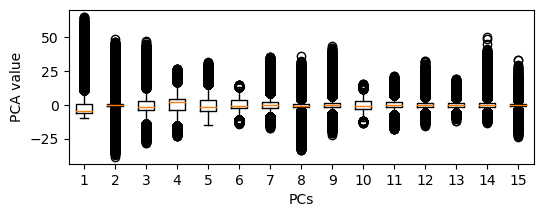

In [35]:
# Check ranges of individual PCs
rcParams['figure.figsize']=(6,2)
_=plt.boxplot(adata_embed.X)
plt.ylabel('PCA value')
plt.xlabel('PCs')

In [4]:
# Compute ASW
asw, asw_macro, asw_data_label=asw_batch(
    X=adata_embed.X,
    batches=adata_embed.obs['system'], 
    labels=adata_embed.obs['cell_type_eval'])

In [6]:
asws={
    'asw_micro':asw,
    'asw_macro':asw_macro,
    'asw_data_label':asw_data_label
}
for k,v in asws.items():
    print(k)
    print(v)
    print('\n')

asw_micro
0.2312154


asw_macro
0.2525119


asw_data_label
acinar           0.328816
alpha            0.186305
alpha+beta       0.217282
beta             0.183074
delta            0.211146
ductal           0.189915
endo. prolif.    0.352205
endothelial      0.263660
gamma            0.166743
immune           0.435940
stellate a.      0.244519
stellate q.      0.250538
dtype: float32




In [7]:
pkl.dump({'asw_batch':asws},open(path_save+'combined_orthologuesHVG_embed_integrationMetrics.pkl','wb'))

## Moran's I for eval
Find genes that would be appropriate for computing Moran's I on for evaluation in every sample-cell type group (of appropriate size) by computing Moran's I on per-sample non integrated data. This can then also be used as a reference later on to compute relative preservation of Moran's I.

In [3]:
adata=sc.read(path_save+'combined_orthologuesHVG.h5ad')

In [6]:
# Potential groups to compute Moran's I on (batch-system and group)
cols=pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 120)
display(pd.crosstab(adata.obs.batch,adata.obs.cell_type_eval))
pd.set_option('display.max_rows', cols)

cell_type_eval,acinar,alpha,alpha+beta,alpha+delta,beta,beta+delta,beta+gamma,delta,delta+gamma,ductal,endo. prolif.,endothelial,gamma,immune,schwann,stellate a.,stellate q.
batch,,,,,,,,,,,,,,,,,
Fltp_2y_MUC13974,8,240,40,12,6445,97,51,205,1,6,8,183,30,172,12,8,7
Fltp_2y_MUC13975,6,184,13,36,2413,50,15,182,8,50,3,447,87,123,9,27,90
Fltp_2y_MUC13976,0,318,36,12,5459,51,28,137,0,1,4,0,30,3,0,0,0
Fltp_P16_145_mGFP,0,4046,15,224,3246,104,37,1060,10,3,227,0,242,1,0,0,0
Fltp_P16_146_mRFP,36,2838,5,60,2628,52,31,320,9,45,161,189,329,90,37,236,88
Fltp_P16_147_mTmG,2,911,0,222,1536,226,11,336,14,17,94,0,92,1,20,2,1
Fltp_adult_mouse1,0,302,0,21,3245,18,19,116,1,1,7,58,251,36,2,12,4
Fltp_adult_mouse2,0,104,1,21,4252,51,3,108,3,0,3,0,116,1,0,0,0
Fltp_adult_mouse3,0,949,1,25,1916,5,1,185,1,5,8,55,6,74,0,3,2


In [25]:
# Filtered groups based on N cells and also remove the doublets
groups=adata.obs.groupby(['cell_type_eval','system','batch']).size()
groups=groups[(groups>=500).values&~groups.index.get_level_values(0).str.contains('\+')]
rows=pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 250)
display(groups)
pd.set_option('display.max_rows', rows)
print('N cell types',groups.index.get_level_values('cell_type_eval').nunique())

cell_type_eval  system  batch                     
acinar          1       HPAP-020                      4850
                        HPAP-021                      1984
                        HPAP-024                      1081
                        HPAP-028                      1649
                        HPAP-032                      1170
                        HPAP-036                       595
                        HPAP-037                      1953
                        HPAP-039                      2119
                        HPAP-042                      1544
                        HPAP-043                       768
                        HPAP-044                      1710
                        HPAP-047                      1359
                        HPAP-065                       696
                        HPAP-071                       692
                        HPAP-082                       788
                        HPAP-087                      6119
     

N cell types 10


In [26]:
# Compute Moran's I per group
data=[]
for group in groups.index:
    # Group adata
    print(group)
    adata_sub=adata[
        (adata.obs.cell_type_eval==group[0]).values&\
        (adata.obs.system==group[1]).values&\
        (adata.obs.batch==group[2]).values,:].copy()
    # Remove lowly expr genes before Moran's I computation as they will be less likely relevant
    # As this is done per small cell group within sample+cell type and HVGs there is not many genes (200-500)
    # so all can be used for Moran's I computation
    sc.pp.filter_genes(adata_sub, min_cells=adata_sub.shape[0]*0.1) 
    # Compute embedding of group
    sc.pp.pca(adata_sub, n_comps=15)
    sc.pp.neighbors(adata_sub, n_pcs=15)
    # Compute I
    morans_i=sc.metrics._morans_i._morans_i(
        g=adata_sub.obsp['connectivities'],
        vals=adata_sub.X.T)
    # Save data
    morans_i=pd.DataFrame({'morans_i':morans_i},index=adata_sub.var_names)
    morans_i['group']=group[0]
    morans_i['system']=group[1]
    morans_i['batch']=group[2]
    data.append(morans_i)
data=pd.concat(data,axis=0)

('acinar', 1, 'HPAP-020')


/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('acinar', 1, 'HPAP-021')
('acinar', 1, 'HPAP-024')
('acinar', 1, 'HPAP-028')
('acinar', 1, 'HPAP-032')
('acinar', 1, 'HPAP-036')
('acinar', 1, 'HPAP-037')
('acinar', 1, 'HPAP-039')
('acinar', 1, 'HPAP-042')
('acinar', 1, 'HPAP-043')
('acinar', 1, 'HPAP-044')
('acinar', 1, 'HPAP-047')
('acinar', 1, 'HPAP-065')
('acinar', 1, 'HPAP-071')
('acinar', 1, 'HPAP-082')
('acinar', 1, 'HPAP-087')
('acinar', 1, 'HPAP-088')
('acinar', 1, 'HPAP-092')
('acinar', 1, 'HPAP-100')
('acinar', 1, 'HPAP-103')
('acinar', 1, 'HPAP-106')
('acinar', 1, 'HPAP-107')
('acinar', 1, 'HPAP-108')
('acinar', 1, 'HPAP-109')
('alpha', 0, 'Fltp_P16_145_mGFP')
('alpha', 0, 'Fltp_P16_146_mRFP')
('alpha', 0, 'Fltp_P16_147_mTmG')
('alpha', 0, 'Fltp_adult_mouse3')
('alpha', 0, 'Fltp_adult_mouse4')
('alpha', 0, 'NOD_elimination_SRR7610297')
('alpha', 0, 'NOD_elimination_SRR7610298')
('alpha', 0, 'NOD_elimination_SRR7610299')
('alpha', 0, 'NOD_elimination_SRR7610300')
('alpha', 0, 'NOD_elimination_SRR7610301')
('alpha', 0, 'NOD

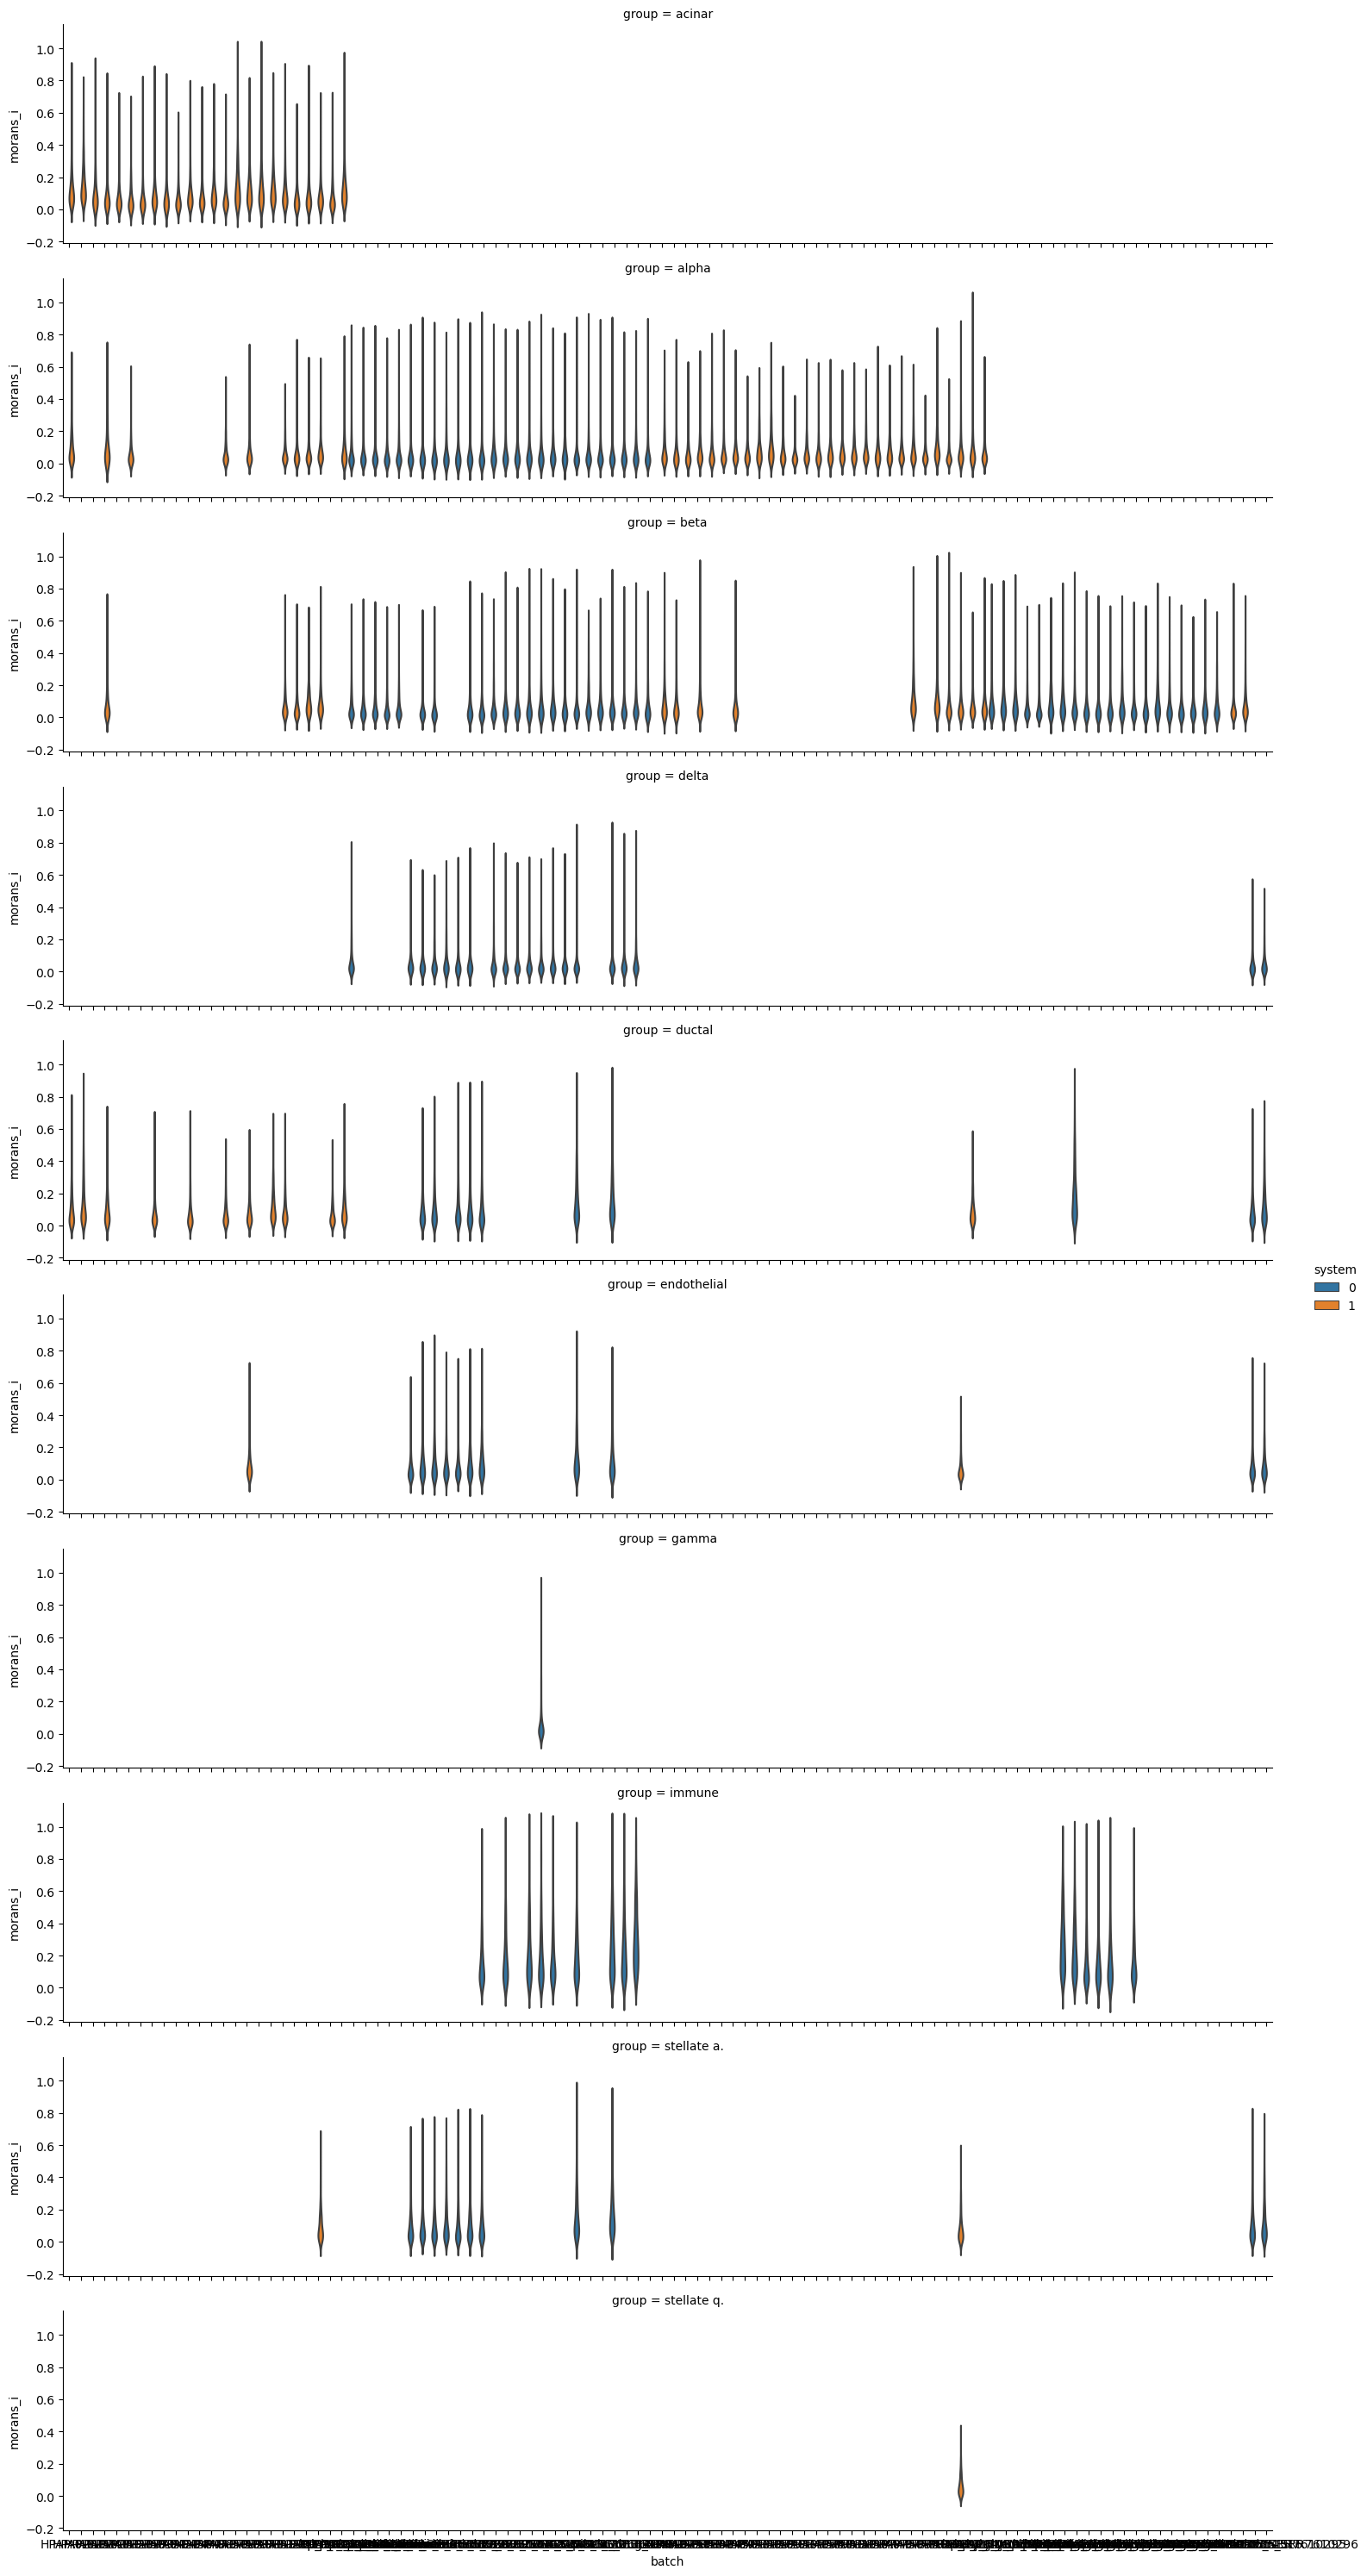

In [28]:
# Moran's I distn accross groups
sb.catplot(x='batch',y='morans_i',hue='system',row='group',data=data,kind='violin',
           inner=None,height=3,aspect=5)

In [29]:
# I thr
thr_mi=0.2

In [31]:
# N genes per group at certain thr
rows=pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 250)
display(data.groupby(['group','system','batch']).apply(lambda x: (x['morans_i']>=thr_mi).sum()))
pd.set_option('display.max_rows', rows)

group        system  batch                     
acinar       1       HPAP-020                      100
                     HPAP-021                      134
                     HPAP-024                       74
                     HPAP-028                       49
                     HPAP-032                       38
                     HPAP-036                       38
                     HPAP-037                       39
                     HPAP-039                       66
                     HPAP-042                       54
                     HPAP-043                       42
                     HPAP-044                       77
                     HPAP-047                       58
                     HPAP-065                       96
                     HPAP-071                       53
                     HPAP-082                      195
                     HPAP-087                      124
                     HPAP-088                      130
                 

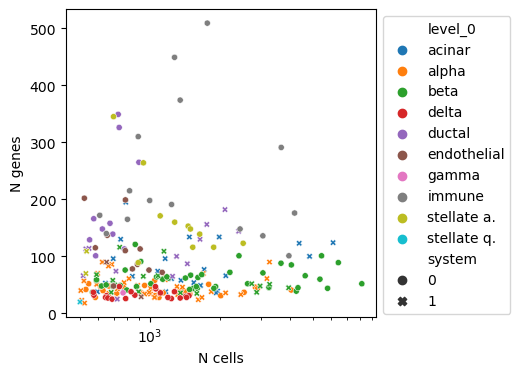

In [35]:
# N genes vs N cells in group
rcParams['figure.figsize']=(4,4)
sb.scatterplot(x='N cells',y='N genes',hue='level_0',style='system',
           data=pd.concat(
    [data.groupby(['group','system','batch']).apply(lambda x: (x['morans_i']>=thr_mi).sum()).rename('N genes'),
    groups.rename('N cells')],axis=1).reset_index(),s=20)
plt.legend(bbox_to_anchor=(1,1))
plt.xscale('log')

C: Thr of 0.2 has at least some genes for every group and not too many in any of the groups. Some groups would need lower/higher thr potentially.

C: There is no clear bias between N cells in group and N genes.

C: Selected genes may not be diverse though - they may capture the same pattern and maybe more subtle patterns are at lower Moran's I.

In [36]:
# Prepare selected genes for saving (fileterd genes&I per group)
selected=list()
for group,data_sub in data.groupby(['group','system','batch']):
    group=dict(zip(['group','system','batch'],group))
    group['genes']=(data_sub.query('morans_i>=@thr_mi')['morans_i']+1)/2
    selected.append(group)

In [9]:
# Save
pkl.dump(selected,open(path_save+'combined_orthologuesHVG_moransiGenes.pkl','wb'))

## Batch effects within and between systems

In [4]:
adata=sc.read(path_save+'combined_orthologuesHVG.h5ad')

In [5]:
# Compute PCA on the whole data
adata_scl=adata.copy()
sc.pp.scale(adata_scl)
n_pcs=15
sc.pp.pca(adata_scl, n_comps=n_pcs)
pca=pd.DataFrame(adata_scl.obsm['X_pca'],index=adata_scl.obs_names)
del adata_scl

In [6]:
# Average PCA accross system-batch-group pseudobulks. 
# Only use pseudobulks with at least 50 cells
# Only use cell types with at least 3 samples per system
pca[['system','mm_study','batch','group']]=adata.obs[['system', 'mm_study','batch', 'cell_type_eval']]
pca['mm_study']=pca['mm_study'].cat.add_categories('hs').fillna('hs')
pca_pb=pca.groupby(['system','mm_study','batch','group'])
pca_mean=pca_pb.mean()
pb_size=pca_pb.size()
# Remove samples with too little cells
filtered_pb=pb_size.index[pb_size>=50]
# Get pbs/cts where both systems have enough samples
n_samples_system=filtered_pb.to_frame().rename({'group':'group_col'},axis=1).groupby(
    'group_col',observed=True)['system'].value_counts().rename('n_samples').reset_index()
cts=set(n_samples_system.query('system==0 & n_samples>=3').group_col)&\
    set(n_samples_system.query('system==1 & n_samples>=3').group_col)
filtered_pb=filtered_pb[filtered_pb.get_level_values(3).isin(cts)]
pca_mean=pca_mean.loc[filtered_pb,:]

In [72]:
# Compute per-ct distances of samples within and between systems
distances={}
for ct in cts:
    # Data for computing distances
    pca_s0=pca_mean[(pca_mean.index.get_level_values(0)==0) &
                    (pca_mean.index.get_level_values(3)==ct)]
    pca_s1=pca_mean[(pca_mean.index.get_level_values(0)==1) &
                    (pca_mean.index.get_level_values(3)==ct)]
    
    # Distances for s0 - within or between datasets
    d_s0=euclidean_distances(pca_s0)
    triu=np.triu_indices(pca_s0.shape[0],k=1)
    idx_map=dict(enumerate(pca_s0.index.get_level_values(1)))
    idx_within=([],[])
    idx_between=([],[])
    for i,j in zip(*triu):
        if idx_map[i]==idx_map[j]:
            idx_list=idx_within
        else:
            idx_list=idx_between
        idx_list[0].append(i)
        idx_list[1].append(j)
    d_s0_within=d_s0[idx_within]
    d_s0_between=d_s0[idx_between]
    
    # Distances for s1 and s0s1
    d_s1=euclidean_distances(pca_s1)[np.triu_indices(pca_s1.shape[0],k=1)]
    d_s0s1=euclidean_distances(pca_s0,pca_s1).ravel()
    distances[ct]={'s0_within':d_s0_within,'s0_between':d_s0_between,'s1':d_s1,'s0s1':d_s0s1}

In [86]:
# Save distances
pkl.dump(distances,open(path_save+'combined_orthologuesHVG_PcaSysBatchDist.pkl','wb'))

In [3]:
# Reload distances
#distances=pkl.load(open(path_save+'combined_orthologuesHVG_PcaSysBatchDist.pkl','rb'))

In [74]:
# Prepare df for plotting
plot=[]
for ct,dat in distances.items():
    for comparison,dist in dat.items():
        dist=pd.DataFrame(dist,columns=['dist'])
        dist['group']=ct
        dist['comparison']=comparison
        plot.append(dist)
plot=pd.concat(plot)

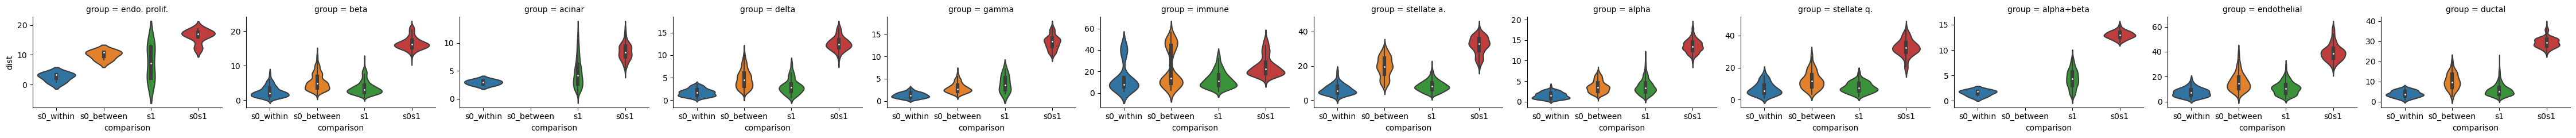

In [75]:
# Plot distances
sb.catplot(x='comparison',y='dist',col='group',
           data=plot.reset_index(drop=True),kind='violin',
           sharey=False, height=2.5,aspect=1.5)

Evaluate statisticsal significance

In [83]:
# Compute significance of differences within and accross systems
signif=[]
for ct,dat in distances.items():
    for ref in ['s0_within','s0_between','s1']:
        n_system=dat[ref].shape[0]
        if n_system>=3:
            u,p=mannwhitneyu( dat[ref],dat['s0s1'],alternative='less')
            signif.append(dict( cell_type=ct,system=ref, u=u,pval=p,
                               n_system=n_system,n_crossystem=dat['s0s1'].shape[0]))
signif=pd.DataFrame(signif)
signif['padj']=multipletests(signif['pval'],method='fdr_bh')[1]

In [84]:
signif

,cell_type,system,u,pval,n_system,n_crossystem,padj
0,endo. prolif.,s0_within,0.0,1.031992e-03,3,16,1.031992e-03
1,endo. prolif.,s0_between,0.0,1.031992e-03,3,16,1.031992e-03
2,endo. prolif.,s1,6.0,4.020747e-04,6,16,4.272044e-04
3,beta,s0_within,0.0,6.579697e-128,205,3172,2.033725e-127
4,beta,s0_between,712.0,0.000000e+00,1121,3172,0.000000e+00
5,beta,s1,20.0,0.000000e+00,1830,3172,0.000000e+00
6,acinar,s0_within,0.0,9.952913e-07,3,180,1.127997e-06
7,acinar,s1,36533.0,1.533455e-65,1770,180,2.896526e-65
8,delta,s0_within,0.0,1.629970e-92,166,833,4.262999e-92
9,delta,s0_between,1159.0,2.804222e-298,1010,833,1.362051e-297


In [85]:
# Save signif
signif.to_csv(path_save+'combined_orthologuesHVG_PcaSysBatchDist_Signif.tsv',sep='\t',index=False)

# Include non-one-to-one orthologues (Saturn, GLUE)

## Prepare data for integration

### Mouse

In [51]:
adata_mm=sc.read(path_mm+'GSE211799_adata_atlas.h5ad')

In [52]:
# Remove embryo and other cts that cant be used
adata_mm=adata_mm[adata_mm.obs.study!='embryo',:]
adata_mm=adata_mm[~adata_mm.obs.cell_type_integrated_v2_parsed.isin(
    ['E endo.','E non-endo.','lowQ',]),:]

In [53]:
# Genes with unique symbols (as Saturn embeddings are symbol based)
unique_gs=set(adata_mm.var_names[~adata_mm.var.duplicated('gene_symbol',keep=False)])

In [54]:
len(unique_gs)

30572

In [48]:
# Add raw expression to X, remove lowly expr genes, and normalise
adata_mm_raw=adata_mm.raw.to_adata()
adata_mm=adata_mm_raw.copy()
adata_mm.layers['counts']=adata_mm_raw[adata_mm.obs_names,adata_mm.var_names].X.copy()
del adata_mm_raw
adata_mm=adata_mm[:,np.array((adata_mm.X>0).sum(axis=0)>20).ravel()]
adata_mm=adata_mm[:,[g for g in adata_mm.var_names if g in unique_gs]]
sc.pp.normalize_total(adata_mm, target_sum=1e4)
sc.pp.log1p(adata_mm)

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
# Add gene symbols as var names for Saturn
adata_mm.var_names=adata_mm.var['gene_symbol']

In [61]:
# HVGs on the final cell subset
sc.pp.highly_variable_genes(
     adata=adata_mm, n_top_genes=3000, flavor='cell_ranger', batch_key='study_sample',
    subset=True)
adata_mm.shape

(263140, 3000)

In [62]:
adata_mm

AnnData object with n_obs × n_vars = 263140 × 3000
    obs: 'study_sample', 'study', 'file', 'reference', 'size_factors_sample', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'sex', 'ins_score', 'ins_high', 'gcg_score', 'gcg_high', 'sst_score', 'sst_high', 'ppy_score', 'ppy_high', 'cell_filtering', 'age', 'strain', 'tissue', 'technique', 'study_sample_design', 'cell_type', 'cell_type_multiplet', 'cell_subtype', 'cell_subtype_multiplet', 'design', 'size_factors_integrated', 'pre_cell_type_unified', 'pre_cell_type_original', 'study_parsed', 'cell_type_parsed', 'low_q', 'BETA-DATA_leiden_r1.5', 'BETA-DATA_leiden_r20', 'BETA-DATA_hc_gene_programs', 'BETA-DATA_hc_gene_programs_parsed', 'BETA-DATA_leiden_r1.5_parsed', 'BETA-DATA_leiden_r1.5_parsed_const', 'CXG-DATA_n_genes', 'CXG-DATA_mt_frac', 'CXG-DATA_doublet_score', 'CXG-DATA_log10_n_counts', 'CXG-DATA_age_approxDays', 'CXG-DATA_cell_subtype_immune_reannotatedIntegrated', 'CXG-DATA_cell_subtype_endothelial_reannotatedIntegra

### Human

In [63]:
adata_hs=sc.read(path_hs+'hpap_islet_scRNAseq.h5ad')

In [64]:
adata_hs

AnnData object with n_obs × n_vars = 192203 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent MT', 'Seurat Clusters', 'Library', 'Sex', 'Diabetes Status', 'Tissue Source', 'Chemistry', 'Cell Type', 'Cell Type Grouped'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [79]:
adata.var_names.nunique()==adata.shape[1]

True

C: No genes have duplicate symbols. May be due to adata var names make unique. But can tfind out as there are also real genes ending in '-N'

In [80]:
# Add raw expression to X, remove lowly expr genes, and normalise
adata_hs=adata_hs[:,np.array((adata_hs.X>0).sum(axis=0)>20).ravel()]
adata_hs.layers['counts']=adata_hs.X.copy()
sc.pp.normalize_total(adata_hs, target_sum=1e4)
sc.pp.log1p(adata_hs)

In [81]:
# HVGs on the final cell subset
sc.pp.highly_variable_genes(
     adata=adata_hs, n_top_genes=3000, flavor='cell_ranger', batch_key='Library',
    subset=True)
adata_hs.shape

(192203, 3000)

In [82]:
adata_hs

AnnData object with n_obs × n_vars = 192203 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent MT', 'Seurat Clusters', 'Library', 'Sex', 'Diabetes Status', 'Tissue Source', 'Chemistry', 'Cell Type', 'Cell Type Grouped'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

### Combine adatas of mm and hs

Map cell type names

In [83]:
adata_mm.obs['cell_type_eval']=adata_mm.obs.cell_type_integrated_v2_parsed
adata_hs.obs['cell_type_eval']=adata_hs.obs['Cell Type'].str.lower().replace({
 'active stellate':'stellate a.',
 'cycling alpha':'endo. prolif.',
 'gamma+epsilon':'gamma',
 'macrophage':'immune',
 'mast':'immune',
 'muc5b+ ductal':'ductal',
 'quiescent stellate':'stellate q.'
})

In [84]:
sorted(adata_mm.obs['cell_type_eval'].unique())

['acinar',
 'alpha',
 'alpha+beta',
 'alpha+delta',
 'beta',
 'beta+delta',
 'beta+gamma',
 'delta',
 'delta+gamma',
 'ductal',
 'endo. prolif.',
 'endothelial',
 'gamma',
 'immune',
 'schwann',
 'stellate a.',
 'stellate q.']

In [85]:
sorted(adata_hs.obs['cell_type_eval'].unique())

['acinar',
 'alpha',
 'alpha+beta',
 'beta',
 'delta',
 'ductal',
 'endo. prolif.',
 'endothelial',
 'gamma',
 'immune',
 'stellate a.',
 'stellate q.']

In [93]:
# Prepare adatas

# Human
obs_keep_hs=['Library', 'Sex', 'Diabetes Status','cell_type_eval']
adata_hs_sub=adata_hs.copy()
adata_hs_sub.obs=adata_hs_sub.obs[obs_keep_hs]
adata_hs_sub.obs.rename({'Library':'batch'}, axis=1, inplace=True)
adata_hs_sub.obs.rename({c:'hs_'+c for c in adata_hs_sub.obs.columns 
                         if c not in ['cell_type_eval','batch']}, 
                         axis=1, inplace=True)
adata_hs_sub.obs['system']=1
del adata_hs_sub.obsm
del adata_hs_sub.uns
del adata_hs_sub.var
# Mouse
adata_mm_sub=adata_mm.copy()
obs_keep_mm=['study_sample', 'study', 'sex','age','study_sample_design', 
              'BETA-DATA_hc_gene_programs_parsed',
              'BETA-DATA_leiden_r1.5_parsed', 'cell_type_eval']
adata_mm_sub.obs=adata_mm_sub.obs[obs_keep_mm]
adata_mm_sub.obs.rename({'study_sample':'batch'}, axis=1, inplace=True)
adata_mm_sub.obs.rename({c:'mm_'+c.replace('BETA-DATA_','') for c in adata_mm_sub.obs.columns 
                         if c not in ['cell_type_eval','batch']}, 
                         axis=1, inplace=True)
adata_mm_sub.obs['system']=0

del adata_mm_sub.obsm
del adata_mm_sub.uns
del adata_mm_sub.var

PCA and clusters for scglue and saturn

In [26]:
# PCA and clusters per system
n_pcs=15
for adata_temp in [adata_hs_sub,adata_mm_sub]:
    adata_sub=adata_temp.copy()
    sc.pp.scale(adata_sub)
    sc.pp.pca(adata_sub, n_comps=n_pcs)
    sc.pp.neighbors(adata_sub, n_pcs=n_pcs)
    sc.tl.leiden(adata_sub)
    adata_temp.obsm['X_pca_system']=adata_sub[adata_temp.obs_names,:].obsm['X_pca']
    adata_temp.obs['leiden_system']=adata_sub.obs.apply(lambda x: str(x['system'])+'_'+x['leiden'],axis=1)
del adata_sub

In [27]:
adata_mm_sub

AnnData object with n_obs × n_vars = 263140 × 3000
    obs: 'batch', 'mm_study', 'mm_sex', 'mm_age', 'mm_study_sample_design', 'mm_hc_gene_programs_parsed', 'mm_leiden_r1.5_parsed', 'cell_type_eval', 'system', 'leiden_system'
    obsm: 'X_pca_system'
    layers: 'counts'

In [28]:
adata_hs_sub

AnnData object with n_obs × n_vars = 192203 × 3000
    obs: 'batch', 'hs_Sex', 'hs_Diabetes Status', 'cell_type_eval', 'system', 'leiden_system'
    obsm: 'X_pca_system'
    layers: 'counts'

#### Save in format for scGLUE/Saturn

In [ ]:
# Save with gene symbols in var names for Saturn
adata_mm_sub.write(path_save+'combined-mmPart_nonortholHVG.h5ad')
adata_hs_sub.write(path_save+'combined-hsPart_nonortholHVG.h5ad')

In [110]:
genes_mm=set(adata_mm_sub.var_names)
genes_hs=set(adata_hs_sub.var_names)
gene_mapping=orthology_info.query('gs_mm in @genes_mm and gs_hs in @genes_hs')[['gs_mm','gs_hs']]
print(gene_mapping.shape[0])
gene_mapping.to_csv(path_save+'combined_nonortholHVG_geneMapping.tsv',index=False,sep='\t')

1646


In [25]:
#adata_mm_sub=sc.read(path_save+'combined-mmPart_nonortholHVG.h5ad')
#adata_hs_sub=sc.read(path_save+'combined-hsPart_nonortholHVG.h5ad')

## Moran's I eval of non-orthol
To make it comparable it must anyway use the same set of genes as above for one-to-one orthologues. So no new Morans'I values/genes are selected.